In [40]:
# Gibeom Lee, HI Lab
# 이 코드는 AC의 frequency 를 측정해주는 코드입니다.
# 만약 TENG ac 전압이라면, 피크를 +/-값 모두 잡아 2배의 frequency가 나올 가능성이 있습니다.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

샘플링 속도: 10000.13 Hz
추정 주기당 샘플 수: 166
최종 피크 height: 0.893
피크 prominence: 0.609
피크 개수: 44
평균 주파수: 44.87 Hz


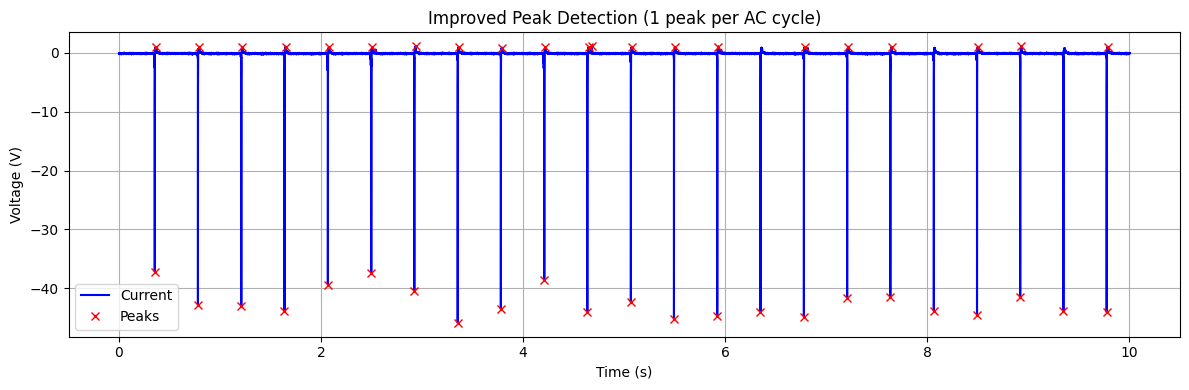

In [ ]:
# -------------------------------
# CSV 파일 경로
file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Leaf inspired DEG\0. 실험자료\2. Collecting data\250403_표만들기2\minimized_각도별\f30-2.csv"


# 데이터 로드
df = pd.read_csv(file_path, header=None, names=["Time", "Current"], skiprows=30)
time = df["Time"].values
current = df["Current"].values

# 샘플링 속도 추정
total_time = time[-1] - time[0]
sampling_rate = len(time) / total_time

# -------------------------------
# 1차 피크 감지: 넉넉하게
mean_val = np.mean(current)
std_val = np.std(current)
rough_height = mean_val + 0.2 * std_val
p_rough_peaks, _ = find_peaks(current, height=rough_height, distance=int(sampling_rate * 0.01))
n_rough_peaks, _ = find_peaks(-current, height=rough_height, distance=int(sampling_rate * 0.01))
rough_peaks = np.sort(np.concatenate([p_rough_peaks, n_rough_peaks]))

rough_peak_times = time[rough_peaks]

# 주기 추정
rough_periods = np.diff(rough_peak_times)
if len(rough_periods) == 0:
    raise ValueError("피크가 너무 적게 감지되어 주기 추정을 못 함")

estimated_period = np.median(rough_periods)
estimated_cycle_len = int(estimated_period * sampling_rate)

# -------------------------------
# 개선된 피크 감지 (정교한 기준 사용)
final_height = mean_val + 0.8 * std_val  # 숫자(최소 전압) 로 기입하여 인위적인 조절 가능.
final_prominence = 0.5 * std_val  # 피크의 명확함 정도 조건 추가

p_peaks, _ = find_peaks(current, height=final_height, distance=int(0.8 * estimated_cycle_len), prominence=final_prominence)
n_peaks, _ = find_peaks(-current, height=final_height, distance=int(0.8 * estimated_cycle_len), prominence=final_prominence)

peaks = np.sort(np.concatenate([p_peaks, n_peaks]))

# -------------------------------
# 주기 및 주파수 계산
peak_times = time[peaks]
periods = np.diff(peak_times)
frequencies = 1 / periods
mean_frequency = np.mean(frequencies) if len(frequencies) > 0 else 0

# -------------------------------
# 출력
print(f"샘플링 속도: {sampling_rate:.2f} Hz")
print(f"추정 주기당 샘플 수: {estimated_cycle_len}")
print(f"최종 피크 height: {final_height:.3f}")
print(f"피크 prominence: {final_prominence:.3f}")
print(f"피크 개수: {len(peaks)}")
print(f"평균 주파수: {mean_frequency:.2f} Hz")

# -------------------------------
# 시각화
plt.figure(figsize=(12, 4))
plt.plot(time, current, label='Current', color='blue')
plt.plot(peak_times, current[peaks], 'rx', label='Peaks')
plt.title("Improved Peak Detection (1 peak per AC cycle)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()